# Toward Real-Time Inference of Neural Receivers with TensorRT

This tutorial demonstrates a proof-of-concept implementation for real-time inference of the proposed neural receiver on a GPU. The input/output shapes are optimized for compatibility with the [NVIDIA Aerial platform](https://developer.nvidia.com/aerial), enabling seamless deployment in a commercial-grade 5G NR ecosystem.

Please note that the exact inference latency depends on various factors, including the hardware platform, the specific neural receiver configuration, and the 5G NR parameters. We have simplified the neural receiver architecture to achieve an inference latency of approximately 1 ms on an NVIDIA A100 GPU. This provides a trade-off between BLER performance and latency.

To minimize latency, we set the batch size to 1, as buffering slots would significantly increase processing latency and is therefore not an option.

This notebook uses [TensorRT](https://developer.nvidia.com/tensorrt) as the inference engine. Refer to the [TensorRT Best Practices](https://docs.nvidia.com/deeplearning/tensorrt/pdf/TensorRT-Best-Practices.pdf) document for more details on the inference performance evaluation.

Running the provided code assumes that the training of the NRX is already
completed. For more details on the training and evaluation pipeline, see the
notebook [Jumpstart into Multi-User MIMO Neural Receiver for 5G NR PUSCH](jumpstart_tutorial.ipynb).

Additional packages required for this notebook include:
- `tf2onnx` and `onnx==1.14` for `export_onnx.py` (available on PyPI)
- `polygraphy` for running the inference pipeline (available on PyPI)
- Full installation of [TensorRT](https://developer.nvidia.com/tensorrt-getting-started) must be installed locally (including GPU drivers). For installation instructions, refer to the [TensorRT Installation Guide](https://docs.nvidia.com/deeplearning/tensorrt/install-guide/index.html). *Hint:* If you are using the Sionna Docker container, you can simply install TensorRT by `sudo apt-get install tensorrt`. This still might require to run `pip install tensorrt` afterwards and by updating the path variable ``export PATH="/usr/src/tensorrt/bin/:$PATH``.

Remark: the Python package `onnx==1.14` is required (`onnx==1.15` does not work due to a known bug).

Known limitations:
- The number of allocated time/frequency resources is static due to current TensorRT limitations. However, padding can be used to keep input/output dimensions constant.
- The DMRS configuration is *baked* into the exported ONNX model (can be made dynamic if required). This approach eliminates the need for pre-computed indices for LS channel estimation.
- Variable MCS schemes are currently not supported in the TensorRT engine for a
  neural receiver with the  *Var-IO* scheme (see [Neural Receiver with Support for Variable Modulation and Coding Schemes](variable_mcs_nrx.ipynb)).
- After the ONNX export, the model cannot be trained anymore. This would currently require to re-run the export scripts to re-generate the engine with new weights.
- The TensorRT engine does not include the FEC decoder and rate-matching. However, this can be done by using components from the Aerial platform.


Please consider this code as a proof-of-concept rather than production-ready. Further, we aim to give researchers an idea of what network dimensions are feasible for real-time deployment.

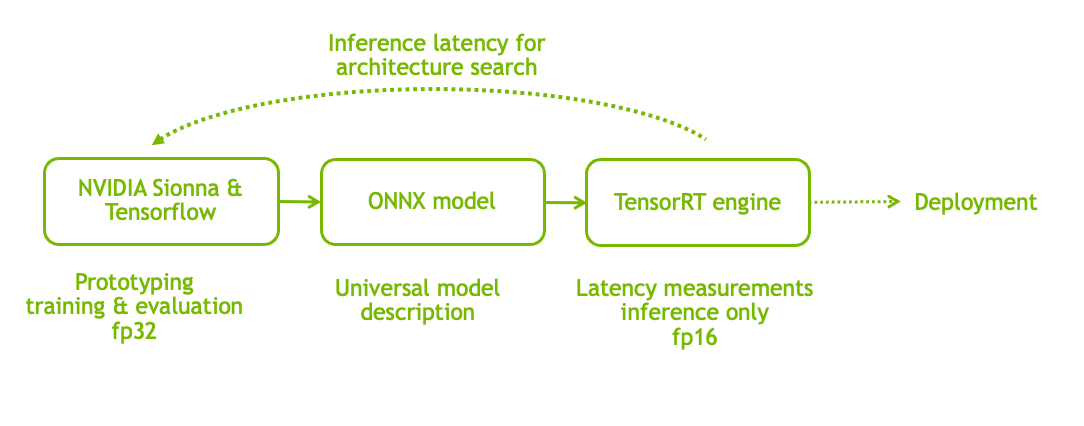

## Table of Contents

* [Exporting the Receiver to TensorRT](#Exporting-the-Receiver-to-TensorRT)
* [Running the TensorRT Engine](#Running-the-TensorRT-Engine)
* [Inference Using TensorRT](#Inference-Using-TensorRT)
* [BLER Performance Validation](#BLER-Performance-Validation)


## GPU Configuration and Imports

In [1]:
gpu_num = 0 # Number of the GPU to be used

# Suppress Tensorflow warnings
import os
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import numpy as np

import tensorflow as tf
tf.get_logger().setLevel('ERROR')

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        print('Only GPU number', gpu_num, 'used.')
        tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        print(e)

# Import libraries
import sys
sys.path.append('../') # to import utils

import sionna as sn
from utils import DataGeneratorAerial, DataEvaluator, Parameters

from polygraphy.backend.common import bytes_from_path
from polygraphy.backend.trt import engine_from_bytes, Profile
from polygraphy.backend.trt.runner import TrtRunner

%load_ext autoreload
%autoreload 2
%matplotlib inline

Only GPU number 0 used.


## Exporting the Receiver to TensorRT

After training, the neural receiver can be exported to the [ONNX](https://onnx.ai/) file format. Note that the exported model uses the weights from the previous training procedure ( `scripts/train_neural_rx.py`), as specified in the configuration file `nrx_rt.cfg`.

The model export can be done by running `scripts/export_onnx.py` which automatically exports
the receiver model to the ONNX file format and builds a TensorRT engine.
Note that the engine is hardware and software platform specific and must be build on your target platform.

In [2]:
# We recommend to run this command in the terminal outside of a jupyter notebook.
#os.environ["PATH"] += os.pathsep + "/usr/src/tensorrt/bin/"   # If this notebook's path variable doesn't include tensorrt
os.system(f"python ../scripts/export_onnx.py -config_name nrx_rt.cfg -num_tx 2 -gpu {gpu_num}");
# the gpu index is only required for multi-gpu systems

# num_tx defines the maximum number of active DMRS ports; less users can be dynamically scheduled by setting the dmrs_port_mask during inference

&&&& RUNNING TensorRT.trtexec [TensorRT v8601] # trtexec --fp16 --onnx=../onnx_models/nrx_rt.onnx --saveEngine=../onnx_models/nrx_rt.plan --minShapes=rx_slot_real:1x1584x14x4,rx_slot_imag:1x1584x14x4,h_hat_real:1x1584x2x4,h_hat_imag:1x1584x2x4 --optShapes=rx_slot_real:1x1584x14x4,rx_slot_imag:1x1584x14x4,h_hat_real:1x1584x2x4,h_hat_imag:1x1584x2x4 --maxShapes=rx_slot_real:1x1584x14x4,rx_slot_imag:1x1584x14x4,h_hat_real:1x1584x2x4,h_hat_imag:1x1584x2x4
[08/07/2024-17:24:35] [I] === Model Options ===
[08/07/2024-17:24:35] [I] Format: ONNX
[08/07/2024-17:24:35] [I] Model: ../onnx_models/nrx_rt.onnx
[08/07/2024-17:24:35] [I] Output:
[08/07/2024-17:24:35] [I] === Build Options ===
[08/07/2024-17:24:35] [I] Max batch: explicit batch
[08/07/2024-17:24:35] [I] Memory Pools: workspace: default, dlaSRAM: default, dlaLocalDRAM: default, dlaGlobalDRAM: default
[08/07/2024-17:24:35] [I] minTiming: 1
[08/07/2024-17:24:35] [I] avgTiming: 8
[08/07/2024-17:24:35] [I] Precision: FP32+FP16
[08/07/2024-17

[08/07/2024-17:24:40] [W] [TRT] onnx2trt_utils.cpp:374: Your ONNX model has been generated with INT64 weights, while TensorRT does not natively support INT64. Attempting to cast down to INT32.
[08/07/2024-17:24:40] [W] [TRT] onnx2trt_utils.cpp:514: Your ONNX model has been generated with double-typed weights, while TensorRT does not natively support double. Attempting to cast down to float.
[08/07/2024-17:24:40] [W] [TRT] onnx2trt_utils.cpp:70: TensorRT is using FLOAT32 precision to run an INT32 ArgMax / ArgMin. Rounding errors may occur for large integer values
[08/07/2024-17:24:40] [W] [TRT] Tensor DataType is determined at build time for tensors not marked as input or output.
[08/07/2024-17:24:40] [W] [TRT] onnx2trt_utils.cpp:70: TensorRT is using FLOAT32 precision to run an INT32 ArgMax / ArgMin. Rounding errors may occur for large integer values
[08/07/2024-17:24:40] [W] [TRT] Tensor DataType is determined at build time for tensors not marked as input or output.


[08/07/2024-17:25:56] [I] [TRT] Detected 7 inputs and 2 output network tensors.
[08/07/2024-17:25:56] [I] [TRT] Total Host Persistent Memory: 109632
[08/07/2024-17:25:56] [I] [TRT] Total Device Persistent Memory: 5120
[08/07/2024-17:25:56] [I] [TRT] Total Scratch Memory: 50383872
[08/07/2024-17:25:56] [I] [TRT] [MemUsageStats] Peak memory usage of TRT CPU/GPU memory allocators: CPU 0 MiB, GPU 128 MiB
[08/07/2024-17:25:56] [I] [TRT] [BlockAssignment] Started assigning block shifts. This will take 75 steps to complete.
[08/07/2024-17:25:56] [I] [TRT] [BlockAssignment] Algorithm ShiftNTopDown took 2.25591ms to assign 8 blocks to 75 nodes requiring 72029184 bytes.
[08/07/2024-17:25:56] [I] [TRT] Total Activation Memory: 72028672
[08/07/2024-17:25:56] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in building engine: CPU +0, GPU +4, now: CPU 0, GPU 4 (MiB)
[08/07/2024-17:25:56] [I] Engine built in 80.2636 sec.


[08/07/2024-17:25:56] [W] [TRT] TensorRT encountered issues when converting weights between types and that could affect accuracy.
[08/07/2024-17:25:56] [W] [TRT] If this is not the desired behavior, please modify the weights or retrain with regularization to adjust the magnitude of the weights.
[08/07/2024-17:25:56] [W] [TRT] Check verbose logs for the list of affected weights.
[08/07/2024-17:25:56] [W] [TRT] - 26 weights are affected by this issue: Detected subnormal FP16 values.


[08/07/2024-17:25:56] [I] [TRT] Loaded engine size: 1 MiB
[08/07/2024-17:25:56] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +0, now: CPU 0, GPU 0 (MiB)
[08/07/2024-17:25:56] [I] Engine deserialized in 0.0071929 sec.
[08/07/2024-17:25:56] [I] [TRT] [MS] Running engine with multi stream info
[08/07/2024-17:25:56] [I] [TRT] [MS] Number of aux streams is 1
[08/07/2024-17:25:56] [I] [TRT] [MS] Number of total worker streams is 2
[08/07/2024-17:25:56] [I] [TRT] [MS] The main stream provided by execute/enqueue calls is the first worker stream
[08/07/2024-17:25:56] [I] [TRT] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +69, now: CPU 0, GPU 69 (MiB)
[08/07/2024-17:25:56] [I] Setting persistentCacheLimit to 0 bytes.
[08/07/2024-17:25:56] [I] Using random values for input rx_slot_real
[08/07/2024-17:25:56] [I] Input binding for rx_slot_real with dimensions 1x1584x14x4 is created.
[08/07/2024-17:25:56] [I]

Remark: if the above code throws an error related to "Could not infer attribute `explicit_paddings` type from empty iterator", please ensure that the `onnx==1.14. There is a known bug in version 1.15 of ONNX causing this issue.

The latency numbers above are for an NVIDIA RTX 3090 GPU.

The compilation script directly provides detailed latency measurements for the given architecture and system hardware.

The reported numbers are obviously platform-specific and can be used to optimize the architecture such that real-time inference is possible.
Further profiling could be done using the [NVIDIA Nsight Systems](https://developer.nvidia.com/nsight-systems).

## Running the TensorRT Engine

We can now run the TRT engine in standalone mode without the need for TensorFlow or Sionna. 

Alternatively, the [ONNX](https://onnx.ai/) model description could be used
within any other neural network acceleration framework for deployment.

Remark: the TRT engine is platform specific (hardware and software), i.e., must be rebuilt for the target platform.
Thus, we do not provide any pre-compiled engines in this repository.

In [3]:
# load pre-compiled TensorRT engine
model_name = "nrx_rt" # equals label in config file
engine = engine_from_bytes(bytes_from_path(f"../onnx_models/{model_name}.plan"))
nrx_trt = TrtRunner(engine) # load the TRT engine
nrx_trt.activate() # and activate TRT engine

[W] 'colored' module is not installed, will not use colors when logging. To enable colors, please install the 'colored' module: python3 -m pip install colored
[I] Loading bytes from ../onnx_models/nrx_rt.plan


### Input/Output NRX Dimensions

The input/output dimensions are aligned with the [NVIDIA Aerial platform](https://developer.nvidia.com/6g-program) and, thus, differ from the definitions in [NVIDIA Sionna](https://nvlabs.github.io/sionna/api/nr.html#puschreceiver).

Remark: Due to the limited support for complex-valued numbers in TensorRT, we define the inputs by their real and imaginary component.
The detailed inputs are as follows:

     rx_slot_real : [batch_size, num_subcarriers, num_ofdm_symbols, num_rx_ant], tf.float32
        Real part of the received OFDM resource grid after cyclic prefix
        removal and FFT.

    rx_slot_imag : [batch_size, num_subcarriers, num_ofdm_symbols, num_rx_ant], tf.float32
        Imaginary part of the received OFDM resource grid after cyclic prefix
        removal and FFT.

    h_hat_real : [batch_size, num_pilots, num_tx, num_rx_ant], tf.float32
        Real part of the LS channel estimates at pilot positions.

    h_hat_imag : [batch_size, num_pilots, num_tx, num_rx_ant], tf.float32
        Imaginary part of the LS channel estimates at pilot positions.

    dmrs_port_mask: [batch_size, max_num_tx], tf.float32
        Mask of 0s and 1s to indicate that DMRS ports are active or not.

    dmrs_ofdm_pos: [num_tx, num_dmrs_symbols], tf.int
        DMRS symbol positions within slot.

    dmrs_subcarrier_pos: [num_tx, num_pilots_per_prb/dmrs_ofdm_pos], tf.int
        Pilot positions per PRB.

And the output shapes are given as:

    llr : [batch_size, num_bits_per_symbol, num_tx, num_effective_subcarriers, num_ofdm_symbols], tf.float
        LLRs on bits. Remark: contrary to Sionna, we use the definition 
        LLR(X) = log[ P(X=0) / P(X=1)].

    h_hat : [batch_size, num_tx, num_effective_subcarriers, num_ofdm_symbols, 2*num_rx_ant], tf.float
        Refined channel estimates.

The batch_size is fixed to 1 during the export.

Remark: TensorRT supports dynamic input shapes during execution. However,
this introduces a small kernel launch overhead whenever the input shapes are changing (e.g., the number of allocated PRBs).
Thus, we currently use a fixed input dimension and consider zero-padding of the non-active PRBs.

To support dynamic shapes, one needs to provide the desired range of input parameters at the end of the
`scripts/export_onnx.py` script.

Note that this implementation requires LS channel estimates at the DMRS pilot positions. 
The main reason for this is that the DMRS pilots depend on various parameters such as the `slot-id` and the `RNTI` which dynamically change.
Thus, integrating an 5G NR LS channel estimator in the TensorRT engine would require a substantially amount of code just for the dynamic DMRS generation.
For this reason, we have decoupled the LS channel estimation from the TensorRT engine and we refer to the [NVIDIA Aerial platform](https://developer.nvidia.com/aerial) which allows for standard compliant dynamic pilot generation.


## Inference Using TensorRT

We now verify the BLER of the system. As mentioned earlier, the input/output shapes of the TensorRT engine are not directly Sionna compatible.

In [4]:
# system parameters as defined in the config
batch_size  = 1 # fixed to one to avoid buffering latency
num_rx_ant = 4
num_ofdm_symbols = 14 # entire grid (nrx slices 12 symbols)
num_tx = 2 # transmitters can be dynamically deactivated via the dmrs_port_mask

num_prbs = 132 # number of occupied PRBs
num_pilots = num_prbs * 6 * 2 # 2 DMRS symbols each with 6 occupied REs

# input specs for trt engine
spec = {
    'rx_slot_real': np.float32,
    'rx_slot_imag': np.float32,
    'h_hat_real': np.float32,
    'h_hat_imag': np.float32,
    'active_dmrs_ports': np.float32,
    'dmrs_ofdm_pos': np.int32,
    'dmrs_subcarrier_pos': np.int32}

################################
### Dummy input data for testing
################################

# received IQ samples
rx_slot = np.ones([batch_size, num_prbs*12, num_ofdm_symbols, num_rx_ant],
                   np.complex64)

# DMRS pilots; only pilots with energy are considered, i.e.,
# masked pilots are ignored
h_hat = np.ones([batch_size, num_pilots, num_tx, num_rx_ant], np.complex64)

# activate all DMRS ports
active_dmrs_ports = np.ones([batch_size, num_tx], np.float32)

dmrs_ofdm_pos = np.array([[2, 11],[2, 11]]) # which OFDM symbols are used for DMRS
dmrs_subcarrier_pos = np.array([[0,2,4,6,8,10],[0,2,4,6,8,10]]) #subcarriers used for pilots (per PRB)

print("----- Inputs -----")
print("rx_slot shape: ", rx_slot.shape)
print("h_hat shape: ", h_hat.shape)
print("active_dmrs_ports shape: ", active_dmrs_ports.shape)
print("dmrs_ofdm_pos shape: ", dmrs_ofdm_pos.shape)
print("dmrs_subcarrier_pos shape: ", dmrs_subcarrier_pos.shape)

# prepare input
feed_dict = {
    'rx_slot_real': rx_slot.real,
    'rx_slot_imag': rx_slot.imag,
    'h_hat_real': h_hat.real,
    'h_hat_imag': h_hat.imag,
    'active_dmrs_ports': active_dmrs_ports,
    'dmrs_ofdm_pos': dmrs_ofdm_pos,
    'dmrs_subcarrier_pos': dmrs_subcarrier_pos}

# and run TensorRT engine
res = nrx_trt.infer({k: feed_dict[k].astype(dt) for k, dt in spec.items()})

llr = res['output_1']
h_hat_refined = res['output_2']

print("\n----- Outputs -----")
print("LLR shape: ", llr.shape)
print("h_hat_refined shape: ", h_hat_refined.shape)

----- Inputs -----
rx_slot shape:  (1, 1584, 14, 4)
h_hat shape:  (1, 1584, 2, 4)
active_dmrs_ports shape:  (1, 2)
dmrs_ofdm_pos shape:  (2, 2)
dmrs_subcarrier_pos shape:  (2, 6)

----- Outputs -----
LLR shape:  (1, 4, 2, 1584, 14)
h_hat_refined shape:  (1, 2, 1584, 14, 8)


## BLER Performance Validation

We use the utility `DataGeneratorAerial` and `DataEvaluator` from `utils/onnx_utils.py` to generate compatible inputs for the NRX and to simulate the BLER of the generated TensorRT engine.

In [5]:
# initialize system parameters for given config
config_name = "nrx_rt.cfg"
sys_parameters = Parameters(config_name, system="nrx", training=False)

# allows to generate test vectors for the NRX via Sionna
data_generator = DataGeneratorAerial(sys_parameters, training=False)

# evaluates LLRs from NRX by applying FEC and BLER calculations
data_evaluator = DataEvaluator(sys_parameters)

Evaluating the first 2 port sets.
Loading DoubleTDL with low correlation.


The DataGenerator generates input data (i.e., slots after transmission over the channel model) for the given system parameters.
The DataEvaluator takes the output of the neural receiver and directly evaluates the BLER (i.e., demaps the resource grid of LLRs and applies FEC decoding).

In [6]:
num_iter = 10 # batches to process
# We have configured TRT to expect a batch size of 1
batch_size = 10 # this is only for DataGeneration
ebno_db = 6.
num_tx = 2 # number of active transmitters

# for BER statistic
num_bit_errors = 0
num_block_errors = 0
num_bits = 0
num_blocks = 0

for i in range(num_iter):

    # this loop runs for batch_size = 1; note that one could draw larger
    # batches and uses an inner loop with batch_size=1 for the TRT engine.
    nrx_inputs, c, b, _ = data_generator(batch_size, ebno_db, num_tx)

    llr = []
    for j in range(batch_size):

        #and run the TRT engine
        feed_dict = {
            'rx_slot_real': nrx_inputs[0][j:j+1],
            'rx_slot_imag': nrx_inputs[1][j:j+1],
            'h_hat_real': nrx_inputs[2][j:j+1],
            'h_hat_imag': nrx_inputs[3][j:j+1],
            'active_dmrs_ports': nrx_inputs[4][j:j+1],
            'dmrs_ofdm_pos': nrx_inputs[5],
            'dmrs_subcarrier_pos': nrx_inputs[6],}

        # and run TensorRT engine
        res = nrx_trt.infer({k: feed_dict[k].astype(dt) for k, dt in spec.items()})

        llr.append(np.copy(res['output_1']))
    #h_hat_refined = res['output_2']

    llr = np.concatenate(llr, axis=0)

    _, ber_uncoded, b_hat = data_evaluator(llr, c)

    # and track BER/BLER
    num_block_errors += sn.utils.count_block_errors(b,b_hat).numpy()
    num_bit_errors += sn.utils.count_errors(b, b_hat).numpy()
    num_blocks += np.prod(b.shape[:-1])
    num_bits += np.prod(b.shape)

    ber = num_bit_errors/num_bits
    bler = num_block_errors / num_blocks

    print(f"Progress {int(i/num_iter*100)}%; BER={ber:.4f},TBLER={bler:.4f}",
          end="\r")
print(f"\nFinal Results: BER={ber:.4f}, TBLER={bler:.4f}")


Progress 90%; BER=0.0000,TBLER=0.0000
Final Results: BER=0.0000, TBLER=0.0000


Remark: most of the compute time in the above example is spend in the `data_generator` and `data_evaluator`.
Throughput benchmarks are not part of this example.

## Outlook

The TensorRT engine is now ready for deployment using the [NVIDIA Aerial platform](https://developer.nvidia.com/aerial).
For further details including code examples of Aerial RAN, please consider joining the [NVIDIA 6G Developer Program](https://developer.nvidia.com/6g-program).